In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_url='https://raw.githubusercontent.com/HarshitaKhare28/Stock_Sentiment_Analysis/refs/heads/main/Reddit_Stock_Sentiment_Data.csv'

df = pd.read_csv(csv_url)
df.head(10)

,Title,Score,URL,Comments,Sentiment
0,GME YOLO update — Jan 28 2021,300570,https://i.redd.it/opzucppb15e61.png,23030,0.4278
1,GME YOLO month-end update — Jan 2021,264707,https://i.redd.it/r557em3t5ce61.png,19912,0.4278
2,GME YOLO update — Feb 19 2021,224567,https://i.redd.it/2xswz0h11ii61.png,12894,0.4278
3,GME YOLO update — Jan 27 2021 ----------------...,218654,https://i.redd.it/a309gkm5yxd61.png,14657,0.4278
4,GME YOLO update — Feb 1 2021,217470,https://i.redd.it/og8ca1xskxe61.png,18067,0.4278
5,Used some of my GME tendies to buy Nintendo Sw...,215191,https://www.nbcdfw.com/news/local/north-texas-...,6999,0.5423
6,GME YOLO update — Apr 16 2021 — final update,175758,https://i.redd.it/n7m08253glt61.png,17881,0.4278
7,GME YOLO update — Mar 8 2021,171939,https://i.redd.it/9jfy2u8bdvl61.png,8075,0.4278
8,GME YOLO update — Feb 2 2021,161707,https://i.redd.it/rr9n7obwq4f61.png,17430,0.4278
9,GME YOLO month-end update — Feb 2021,150753,https://i.redd.it/20ro9puizvj61.png,7649,0.4278


In [2]:
df.shape

(88, 5)

In [3]:
df.tail(10)

,Title,Score,URL,Comments,Sentiment
78,To all GME holders: Shut up and listen,55581,https://www.reddit.com/r/wallstreetbets/commen...,5459,0.0000
79,Just bought 87 shares of GME from Saudi Arabia...,54639,https://i.redd.it/zwnlmicofve61.jpg,1487,0.2960
80,RobinHood CEO when responding to Chris Cuomo o...,54201,https://v.redd.it/33lscffgm9e61,897,0.0000
81,Trying to time a TSLA trade,54150,https://v.redd.it/qqrpx54psno61,836,0.0000
82,If your friends and family are wondering why y...,53077,https://www.reddit.com/r/wallstreetbets/commen...,3160,0.6808
83,"Been an AMC employee for 5+ years, so thanks f...",53035,https://i.redd.it/g7eeiqkzkxe61.png,1140,0.5777
84,$GME shorties yesterday vs today,52251,https://i.redd.it/tc9lwshci7p61.gif,1087,0.0000
85,Bill Gross is short GME. Selling $250 and $300...,52188,https://i.redd.it/pqnbbr0z2gn61.jpg,2341,-0.4767
86,Volume is low. Don’t believe the news. No one ...,50534,https://i.redd.it/q3xpvdnn4xe61.jpg,2478,-0.5106
87,The SEC Just posted the new numbers for Failur...,49444,https://www.reddit.com/r/wallstreetbets/commen...,3424,-0.7650


### Data Cleaning and PreProcessing

In [4]:
#checking for null values
print("Checking for null values:")
print(df.isnull().sum())
if df.isnull().sum().sum() > 0:
    df.fillna(method='ffill', inplace=True)  
    
# Checking for duplicates
if df.duplicated().sum() > 0:
    print(f"Found {df.duplicated().sum()} duplicate rows. Removing them...")
    df.drop_duplicates(inplace=True)

# Removing outliers if necessary (using z-score or IQR method)
from scipy import stats
z_scores = stats.zscore(df.select_dtypes(include=[float, int]))
# Remove rows where z-score > 3
df = df[(abs(z_scores) < 3).all(axis=1)]  

# Resetting index after cleaning
df.reset_index(drop=True, inplace=True)

# Printing the cleaned dataset summary
print("Data after cleaning:")
print(df.info())

Checking for null values:
Title        0
Score        0
URL          0
Comments     0
Sentiment    0
dtype: int64
Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      84 non-null     object 
 1   Score      84 non-null     int64  
 2   URL        84 non-null     object 
 3   Comments   84 non-null     int64  
 4   Sentiment  84 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.4+ KB
None


### Sentiment Categorization

In [5]:
# sentiment categorization
def categorize_sentiment(score):
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

df['Sentiment_Category'] = df['Sentiment'].apply(categorize_sentiment) 

# counting the frequency of mentions
tickers = ['GME', 'AMC', 'TSLA', 'AAPL', 'MSFT']
mentions = {ticker: df['Title'].str.contains(ticker).sum() for ticker in tickers}
mentions_df = pd.DataFrame(list(mentions.items()), columns=['Stock', 'Mentions'])

print(mentions_df)

# Average sentiment per stock
avg_sentiment = {ticker: df[df['Title'].str.contains(ticker)]['Sentiment'].mean() for ticker in tickers}
sentiment_df = pd.DataFrame(list(avg_sentiment.items()), columns=['Stock', 'Average Sentiment'])

print(sentiment_df)

  Stock  Mentions
0   GME        78
1   AMC        10
2  TSLA         1
3  AAPL         0
4  MSFT         0
  Stock  Average Sentiment
0   GME           0.099372
1   AMC           0.036400
2  TSLA           0.000000
3  AAPL                NaN
4  MSFT                NaN


#### Topic Modeling

In [6]:
import nltk
from nltk.corpus import stopwords
import gensim
from gensim import corpora

nltk.download('stopwords')

# Prepare your text data
texts = df['Title'].astype(str).tolist()
stop_words = set(stopwords.words('english'))

# Tokenize and remove stop words
processed_texts = [
    [word for word in gensim.utils.simple_preprocess(text) if word not in stop_words]
    for text in texts
]

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# LDA Model
lda_model = gensim.models.LdaMulticore(
    corpus,
    num_topics=5,  # Adjust the number of topics as needed
    id2word=dictionary,
    passes=10,
    workers=2
)

# Print the topics discovered by the LDA model
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(0, '0.074*"gme" + 0.013*"price" + 0.013*"well" + 0.013*"real" + 0.013*"buying"')
(1, '0.094*"gme" + 0.050*"update" + 0.047*"yolo" + 0.015*"amc" + 0.015*"jan"')
(2, '0.036*"gme" + 0.017*"amc" + 0.016*"gamestop" + 0.011*"shares" + 0.011*"us"')
(3, '0.063*"gme" + 0.022*"buying" + 0.017*"going" + 0.012*"let" + 0.012*"stop"')
(4, '0.072*"gme" + 0.016*"today" + 0.011*"squeeze" + 0.011*"hold" + 0.011*"trying"')


### Grouping and Aggregation

In [7]:
import yfinance as yf
# Grouping and Aggreagating by stock ticker
grouped_sentiment = df.groupby('Sentiment_Category').size().reset_index(name='Counts')
print("Grouped Sentiment Counts:")
print(grouped_sentiment)

tickers = ['GME', 'AMC', 'TSLA', 'AAPL', 'MSFT']
price_data = yf.download(tickers, start='2023-01-01', end='2024-01-01')

# Ensure the index is a DateTimeIndex
price_data.reset_index(inplace=True)

Grouped Sentiment Counts:
  Sentiment_Category  Counts
0           negative      19
1            neutral      26
2           positive      39


[*********************100%***********************]  5 of 5 completed


### Visualization

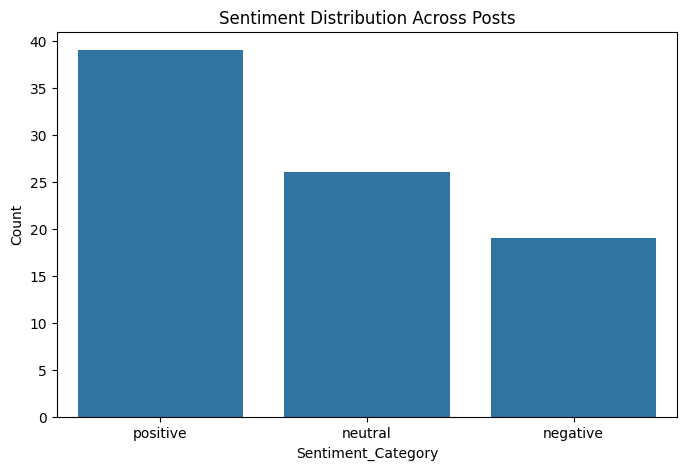

In [8]:
# visualization of sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment_Category', data=df)
plt.title('Sentiment Distribution Across Posts')
plt.ylabel('Count')
plt.show()

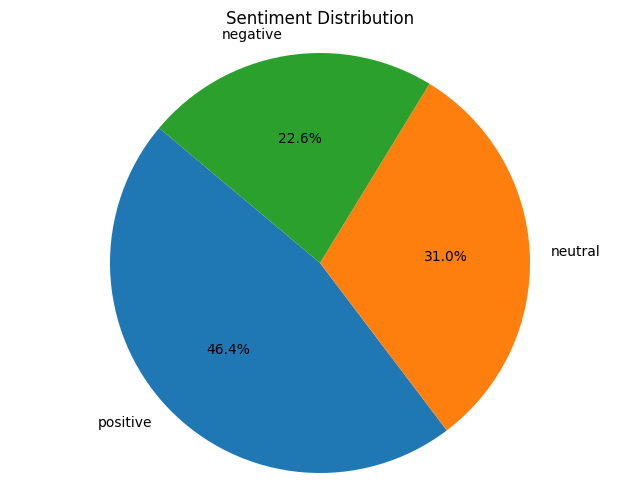

In [9]:
sentiment_counts = df['Sentiment_Category'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular
plt.show()


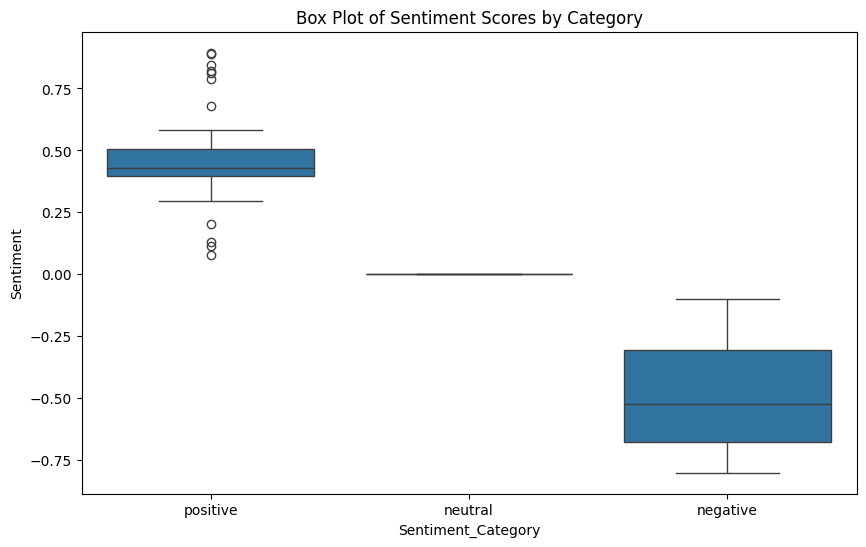

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment_Category', y='Sentiment', data=df)
plt.title('Box Plot of Sentiment Scores by Category')
plt.show()


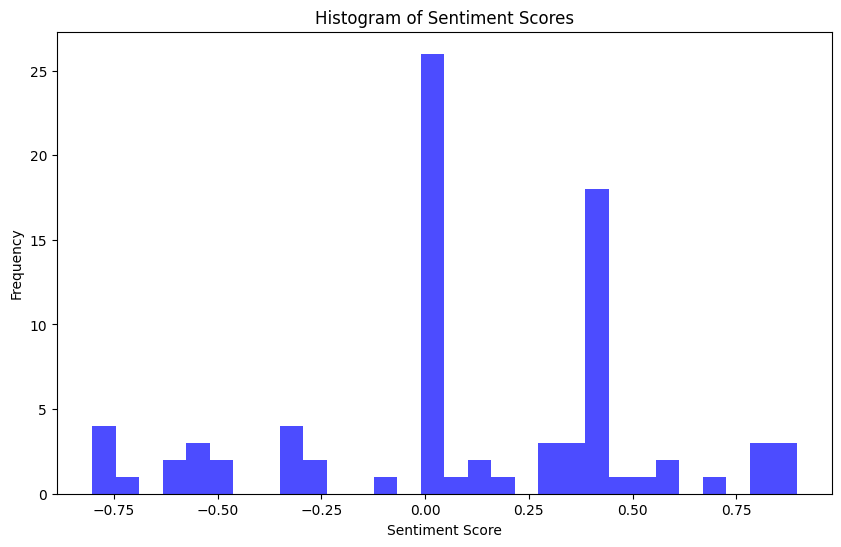

In [11]:
# Create a histogram for sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(df['Sentiment'], bins=30, color='blue', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Scores')
plt.show()


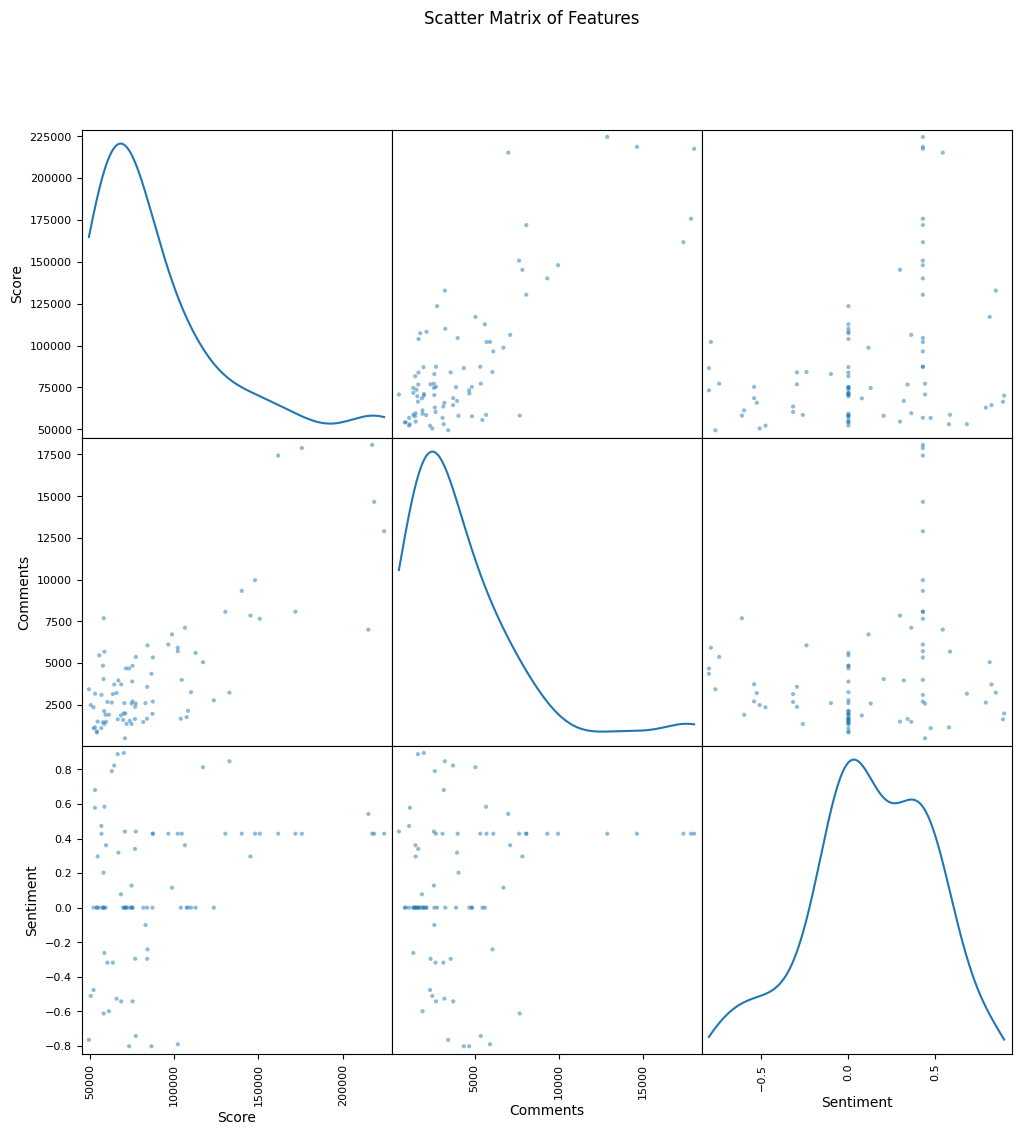

In [12]:
from pandas.plotting import scatter_matrix

# Create a scatter matrix
scatter_matrix(df, figsize=(12, 12), diagonal='kde')
plt.suptitle('Scatter Matrix of Features')
plt.show()


[*********************100%***********************]  5 of 5 completed


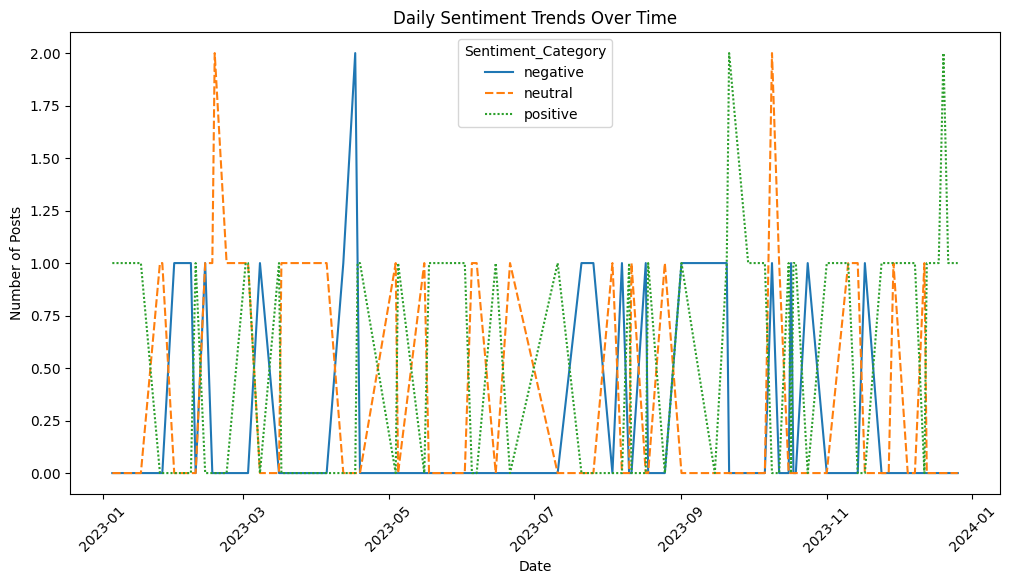

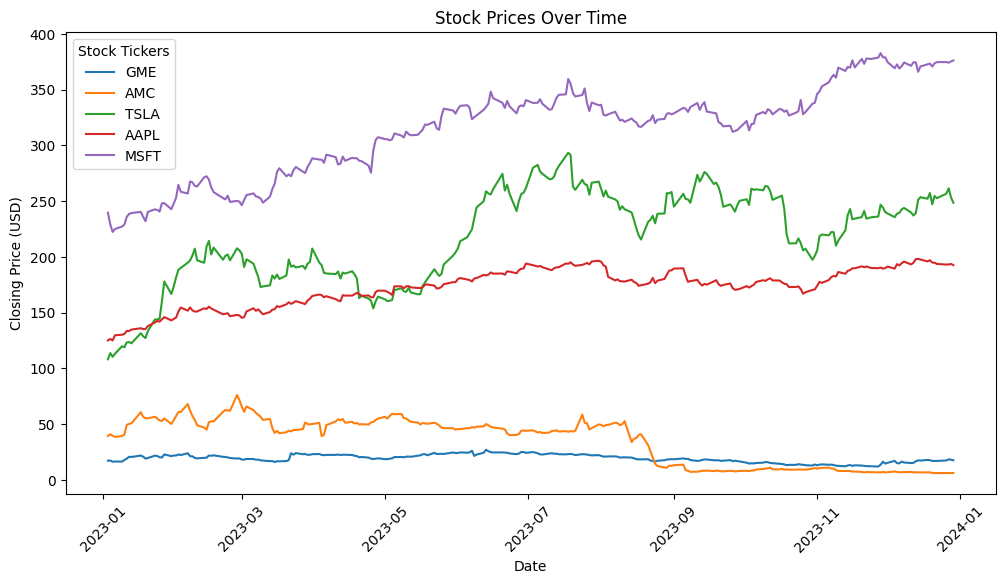

In [13]:
import numpy as np

price_data = yf.download(tickers, start='2023-01-01', end='2024-01-01')

# Adding Date Column
price_data.reset_index(inplace=True)  

# Assigning random dates from the stock price data to sentiment posts (for demo purposes)
df['Date'] = np.random.choice(price_data['Date'], size=len(df))

# Grouping by the newly added Date and Sentiment Category to track trends
daily_sentiment = df.groupby([df['Date'], 'Sentiment_Category']).size().unstack().fillna(0)

# Plot the time-series trend of sentiment categories
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_sentiment)
plt.title('Daily Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

# Plot stock price trends for the same period
plt.figure(figsize=(12, 6))
for ticker in tickers:
    sns.lineplot(x=price_data['Date'], y=price_data['Close'][ticker], label=ticker)

plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.xticks(rotation=45)
plt.legend(title="Stock Tickers")
plt.show()


In [14]:
# Fetching historical stock prices for correlation analysis
# Download historical price data
price_data = yf.download(tickers, start='2023-01-01', end='2024-01-01')
print(price_data.head())

# Analyzing average prices for each ticker
avg_prices = price_data['Close'].mean()  # Get the average closing prices
print("Average Closing Prices:\n", avg_prices)

[*********************100%***********************]  5 of 5 completed

Price                       Adj Close                                    \
Ticker                           AAPL        AMC        GME        MSFT   
Date                                                                      
2023-01-03 00:00:00+00:00  123.904633  39.299999  17.200001  236.183533   
2023-01-04 00:00:00+00:00  125.182617  40.900002  17.320000  225.852097   
2023-01-05 00:00:00+00:00  123.855095  39.599998  16.219999  219.158356   
2023-01-06 00:00:00+00:00  128.412231  38.500000  16.459999  221.741226   
2023-01-09 00:00:00+00:00  128.937271  39.299999  16.379999  223.900146   

Price                                       Close                        \
Ticker                           TSLA        AAPL        AMC        GME   
Date                                                                      
2023-01-03 00:00:00+00:00  108.099998  125.070000  39.299999  17.200001   
2023-01-04 00:00:00+00:00  113.639999  126.360001  40.900002  17.320000   
2023-01-05 00:00:00+00:0

# Conclusion

In this analysis, I performed a comprehensive exploration of the relationship between social media sentiment and stock prices for selected companies. The steps included:

### Data Cleaning

I began by ensuring that the dataset was clean and free of any missing values. This step was crucial for maintaining the integrity of our analysis. I followed these steps:
1. **Handling Missing Values**: I checked for any null values in the dataset. If missing values were present, they were handled using the **forward fill** method, which propagates the last valid observation forward. This ensured that no critical data points were lost.
2. **Removing Duplicates**: The dataset was scanned for duplicate entries. Any duplicate rows found were removed to avoid redundancy and ensure the dataset's uniqueness.
3. **Outlier Detection and Removal**: I used the **z-score** method to identify and remove outliers from numeric columns. Data points that deviated by more than 3 standard deviations from the mean were considered outliers and were eliminated. This step helped maintain a more representative dataset for analysis.
4. **Index Reset**: After cleaning the data, the index of the DataFrame was reset to ensure continuity, especially after removing rows.

At this point, the dataset was cleaned and ready for further analysis or modeling.


### Sentiment Categorization
I applied sentiment analysis to the collected Reddit posts using the VADER sentiment analysis tool. This allowed us to categorize sentiments into positive, negative, and neutral.

### Grouping and Aggregation
Following sentiment categorization, I grouped the data based on stock tickers to analyze average sentiment scores. This aggregation provided a clearer view of how sentiment fluctuated across different stocks.

### Visualization
To visualize our findings, I created several plots:
- **Pie Chart**: Displayed the distribution of sentiment categories.
- **Box Plot**: Illustrated the spread of sentiment scores across categories.
- **Histogram**: Provided insights into the distribution of sentiment scores.
- **Scatter Matrix**: Showed pairwise relationships between multiple features.
- **Time-Series Plot**: Tracked the trends of stock prices and sentiment categories over time, showing how stock prices and social media sentiment evolved during the selected period. This allowed for a comparison between stock movements and the corresponding sentiment dynamics.

The time-series plot helps identify potential correlations between sentiment trends and stock price fluctuations.


These visualizations helped in identifying trends and patterns in the data.

### Report Findings/Predictions
Based on the analysis, I observed potential correlations between sentiment and stock price movements:
- **GameStop (GME)** shows a strong correlation between negative sentiment and price drops; it could be a signal for traders to take caution.
- **Tesla (TSLA)** indicates that positive sentiment often aligns with price increases, suggesting a potential buying opportunity.

### Actionable Insights
- Traders should monitor sentiment trends closely, as shifts in sentiment may indicate upcoming price changes.
- Stocks with significant negative sentiment might warrant caution or short-selling strategies, while stocks with positive sentiment could represent buying opportunities.

### Future Improvements
To enhance this analysis, I suggest:
- **Integrating Data from Multiple Sources**: Incorporating data from news articles, financial reports, or earnings calls could provide a more holistic view of market sentiment.
- **Utilizing Advanced Sentiment Analysis Techniques**: Exploring machine learning models for sentiment analysis could improve accuracy by capturing nuances in language.

By continuously refining our approach and integrating diverse data sources, we can develop more robust trading strategies that account for evolving market dynamics.
